In [28]:
%load_ext autoreload
%load_ext lab_black
%autoreload 2

import admix
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from os.path import join
import seaborn as sns
from scipy.stats import pearsonr

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The lab_black extension is already loaded. To reload it, use:
  %reload_ext lab_black


In [29]:
# read local ancestry
df_lanc = pd.read_csv("out/admix_lanc.tsv", sep="\t", index_col=0)
df_lanc["lanc"] = 1.0 - df_lanc["lanc"]
df_lanc["lanc_q"] = pd.qcut(df_lanc.lanc, q=5).cat.codes + 1

In [33]:
prefix = "hsq-0.25-pcausal-0.01-hermodel-uniform"
df_sum = pd.read_csv(f"out/summary/{prefix}.tsv.gz", sep="\t")

In [34]:
df_plot = {
    "group": [],
    "sim_i": [],
    "coverage": [],
    "method": [],
    "R2": [],
    "avg_len": [],
}
for group, df_group in df_sum.groupby(["GROUP", "SIM_I"]):
    df_group = df_group[df_group.IN_CAL == False]
    for method in ["CENTER", "SHIFT", "SCALE"]:
        lower = df_group[f"{method}_PRS_Q_0.1"]
        upper = df_group[f"{method}_PRS_Q_0.9"]
        center = (lower + upper) / 2
        pheno = df_group.PHENO
        coverage = np.mean((lower <= pheno) & (pheno < upper))
        df_plot["group"].append(group[0])
        df_plot["sim_i"].append(group[1])
        df_plot["coverage"].append(coverage)
        df_plot["method"].append(method)
        df_plot["R2"].append(pearsonr(center, pheno)[0] ** 2)
        df_plot["avg_len"].append(np.mean(upper - lower))

df_plot = pd.DataFrame(df_plot)
df_plot["method"] = df_plot["method"].replace("CENTER", "Raw")
df_plot["method"] = df_plot["method"].replace("SCALE", "Calibrated")
df_plot = df_plot[df_plot.method.isin(["Raw", "Calibrated"])]

# Coverage property

[Text(0, 0, 'EUR'),
 Text(1, 0, 'Admixed (1)'),
 Text(2, 0, 'Admixed (2)'),
 Text(3, 0, 'Admixed (3)'),
 Text(4, 0, 'Admixed (4)'),
 Text(5, 0, 'Admixed (5)')]

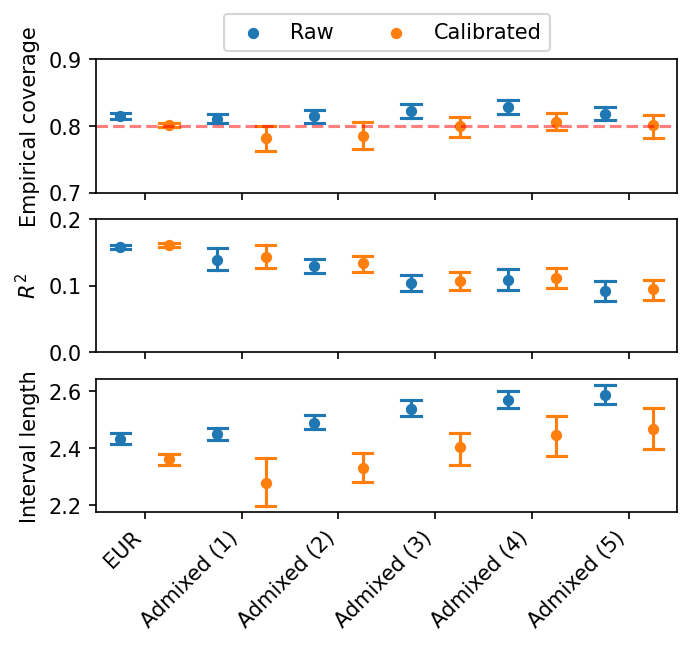

In [35]:
fig, axes = plt.subplots(figsize=(5, 4), dpi=150, sharex=True, nrows=3)

# Empirical coverage

ax = axes[0]
sns.pointplot(
    x="group",
    y="coverage",
    order=["eur_test"] + [f"admix_{i}" for i in range(1, 6)],
    hue="method",
    dodge=0.5,
    data=df_plot,
    errwidth=1.5,
    capsize=0.2,
    markers=".",
    join=False,
    ax=ax,
)
ax.axhline(y=0.8, ls="--", color="red", alpha=0.5)
ax.set_ylim(0.7, 0.9)
ax.set_xlabel(None)

ax.legend(loc="center", bbox_to_anchor=(0.5, 1.2), ncol=3)
ax.set_ylabel("Empirical coverage")

# R2
ax = axes[1]

sns.pointplot(
    x="group",
    y="R2",
    order=["eur_test"] + [f"admix_{i}" for i in range(1, 6)],
    hue="method",
    dodge=0.5,
    data=df_plot,
    errwidth=1.5,
    capsize=0.2,
    markers=".",
    join=False,
    ax=ax,
)

ax.set_ylim(0, 0.2)
ax.get_legend().remove()
ax.set_xlabel(None)
ax.set_ylabel("$R^2$")

ax = axes[2]

sns.pointplot(
    x="group",
    y="avg_len",
    order=["eur_test"] + [f"admix_{i}" for i in range(1, 6)],
    hue="method",
    dodge=0.5,
    data=df_plot,
    errwidth=1.5,
    capsize=0.2,
    markers=".",
    join=False,
    ax=ax,
)
ax.set_xticklabels(
    ["EUR"] + [f"Admixed ({i})" for i in range(1, 6)], rotation=45, ha="right"
)
ax.get_legend().remove()
ax.set_xlabel(None)
ax.set_ylabel("Interval length")
# ax.set_ylim(2, 3)

ax.set_xticklabels(
    ["EUR"] + [f"Admixed ({i})" for i in range(1, 6)], rotation=45, ha="right"
)

# R2 ~ ancestry
# Predictive interval ~ ancestry

In [96]:
df_plot = {"group": [], "sim_i": [], "coverage": [], "method": []}
for group, df_group in df_sum.groupby(["GROUP", "SIM_I"]):
    df_group = df_group[df_group.IN_CAL == False]
    for method in ["CENTER", "SHIFT", "SCALE"]:
        coverage = np.mean(
            (df_group[f"{method}_PRS_Q_0.1"] <= df_group.PHENO)
            & (df_group.PHENO < df_group[f"{method}_PRS_Q_0.9"])
        )
        df_plot["group"].append(group[0])
        df_plot["sim_i"].append(group[1])
        df_plot["coverage"].append(coverage)
        df_plot["method"].append(method)
df_plot = pd.DataFrame(df_plot)

fig, ax = plt.subplots(figsize=(5, 1.5), dpi=150)
sns.pointplot(
    x="group",
    y="coverage",
    order=["eur_test"] + [f"admix_{i}" for i in range(1, 6)],
    hue="method",
    dodge=0.5,
    data=df_plot,
    errwidth=1.5,
    capsize=0.2,
    markers=".",
    join=False,
    ax=ax,
)
ax.axhline(y=0.8, ls="--", color="red", alpha=0.5)
ax.set_ylim(0.75, 0.85)
ax.set_xticklabels(
    ["EUR"] + [f"Admixed ({i})" for i in range(1, 6)], rotation=45, ha="right"
)
ax.legend(loc="center", bbox_to_anchor=(0.5, 1.15), ncol=3)
ax.set_ylabel("Empirical coverage")

,INDIV,GROUP,PHENO,IN_CAL,SIM_I,PRS_Q_0.1,PRS_Q_0.9,CENTER_PRS_Q_0.1,CENTER_PRS_Q_0.9,SHIFT_PRS_Q_0.1,SHIFT_PRS_Q_0.9,SCALE_PRS_Q_0.1,SCALE_PRS_Q_0.9
0,1000102_1000102,eur_test,-2.407027,False,0,-0.882906,1.511530,-0.871168,1.523267,-0.844526,1.496625,-0.860757,1.472609
1,1000774_1000774,eur_test,-0.668323,False,0,-0.969184,1.335556,-1.005203,1.299537,-0.973280,1.267614,-0.977356,1.260843
2,1000807_1000807,eur_test,-1.231381,True,0,-1.713227,0.868013,-1.731653,0.849587,-1.699821,0.817756,-1.727786,0.779498
3,1001523_1001523,eur_test,-1.668207,True,0,-1.008996,1.233444,-1.031801,1.210638,-0.998800,1.177636,-1.056508,1.119889
4,1001531_1001531,eur_test,-0.231267,False,0,-1.064808,1.315478,-1.126079,1.254208,-1.073623,1.201752,-1.125231,1.152819
...,...,...,...,...,...,...,...,...,...,...,...,...,...
255705,6022871_6022871,admix_5,-0.057291,True,9,-1.654938,1.096615,-1.205501,1.546051,-1.122821,1.463370,-1.107046,1.505583
255706,6023479_6023479,admix_3,1.096071,False,9,-0.972379,1.578225,-0.502986,2.047618,-0.438081,1.982713,-0.389652,2.047721
255707,6024954_6024954,admix_3,1.276922,True,9,-0.958874,1.631301,-0.486540,2.103635,-0.464968,2.082063,-0.520195,2.095959
255708,6025478_6025478,admix_2,0.540803,True,9,-1.066111,1.482437,-0.539007,2.009540,-0.493168,1.963701,-0.546571,1.930361


In [9]:
df_plot = df_sum.copy()
df_plot["lanc"] = df_lanc.reindex(df_plot["INDIV"]).lanc.values
df_plot = df_plot[df_plot.SIM_I == 3]

In [10]:
import statsmodels.api as sm
from scipy.stats import pearsonr

In [13]:
df_group

,INDIV,GROUP,PHENO,IN_CAL,SIM_I,PRS_Q_0.1,PRS_Q_0.9,CENTER_PRS_Q_0.1,CENTER_PRS_Q_0.9,SHIFT_PRS_Q_0.1,SHIFT_PRS_Q_0.9,SCALE_PRS_Q_0.1,SCALE_PRS_Q_0.9
178997,1000102_1000102,eur_test,0.609090,False,9,-0.762793,1.608897,-0.255910,2.115780,-0.217434,2.077304,-0.218068,2.081766
178998,1000774_1000774,eur_test,-0.570164,False,9,-0.826630,1.536513,-0.303951,2.059193,-0.277592,2.032834,-0.295345,2.017819
179001,1001531_1001531,eur_test,1.198312,False,9,-0.579086,1.892810,-0.044863,2.427033,-0.016943,2.399113,-0.123136,2.285959
179002,1001652_1001652,eur_test,-0.240375,False,9,-0.253826,2.158970,0.258403,2.671198,0.278721,2.650880,0.279096,2.655250
179003,1001763_1001763,eur_test,2.343284,False,9,-0.082298,2.420529,0.443312,2.946139,0.470217,2.919234,0.565248,3.015049
...,...,...,...,...,...,...,...,...,...,...,...,...,...
200240,6024172_6024172,eur_test,-0.872482,False,9,-1.147100,1.206504,-0.636061,1.717543,-0.608413,1.689895,-0.544648,1.754737
200241,6024190_6024190,eur_test,0.981166,False,9,-0.327255,1.943623,0.229305,2.500182,0.257888,2.471599,0.333458,2.542714
200243,6025446_6025446,eur_test,0.953745,False,9,-0.388205,1.926964,0.140083,2.455252,0.164813,2.430523,0.164141,2.429783
200244,6025686_6025686,eur_test,3.119911,False,9,0.184313,2.761201,0.726889,3.303777,0.758886,3.271780,0.736919,3.239505


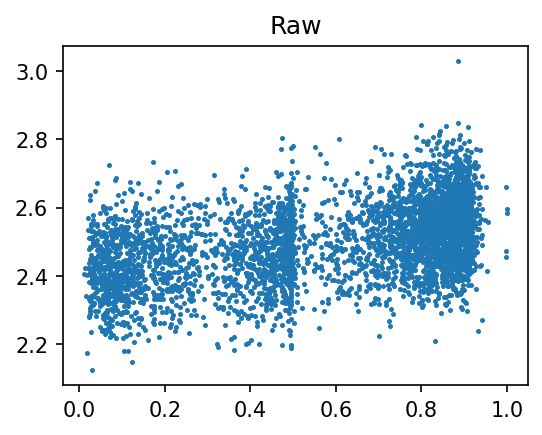

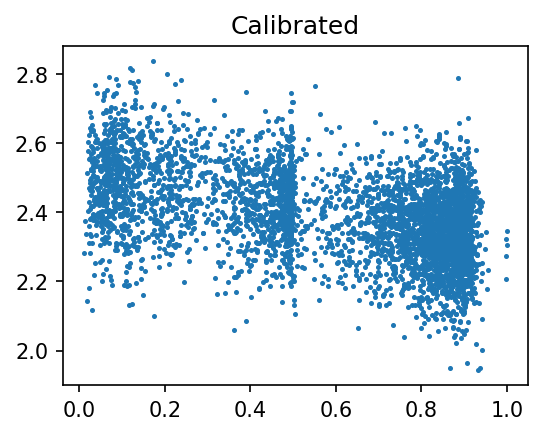

group=admix_1, coverage=0.82, raw_r2=0.14870587823176362, cal_r2=0.15699880053261508
group=admix_2, coverage=0.79, raw_r2=0.16994540068691794, cal_r2=0.18069866046098004
group=admix_3, coverage=0.8, raw_r2=0.09879009844297418, cal_r2=0.09983856893476553
group=admix_4, coverage=0.78, raw_r2=0.11194322991642056, cal_r2=0.10812424616254944
group=admix_5, coverage=0.76, raw_r2=0.07922181083373646, cal_r2=0.08524017397177037
group=eur_test, coverage=0.81, raw_r2=0.15344484086692867, cal_r2=0.15553599484218686


In [15]:
fig, ax = plt.subplots(figsize=(4, 3), dpi=150)
ax.scatter(df_plot.lanc, df_plot["PRS_Q_0.9"] - df_plot["PRS_Q_0.1"], s=2)
ax.set_title("Raw")
plt.show()

fig, ax = plt.subplots(figsize=(4, 3), dpi=150)
ax.scatter(df_plot.lanc, df_plot["SCALE_PRS_Q_0.9"] - df_plot["SCALE_PRS_Q_0.1"], s=2)
ax.set_title("Calibrated")
plt.show()


for group, df_group in df_plot.groupby(["GROUP"]):
    df_group = df_group[df_group.IN_CAL == False]
    coverage = np.mean(
        (df_group["SCALE_PRS_Q_0.1"] <= df_group.PHENO)
        & (df_group.PHENO < df_group["SCALE_PRS_Q_0.9"])
    )
    raw_r2 = (
        pearsonr(df_group["PHENO"], df_group["PRS_Q_0.1"] + df_group["PRS_Q_0.9"])[0]
        ** 2
    )
    cal_r2 = (
        pearsonr(
            df_group["PHENO"], df_group["SCALE_PRS_Q_0.1"] + df_group["SCALE_PRS_Q_0.9"]
        )[0]
        ** 2
    )

    print(f"group={group}, coverage={coverage:.2g}, raw_r2={raw_r2}, cal_r2={cal_r2}")

In [ ]:
# before calibration
df_admix_plot = df_summary[df_summary.GROUP.str.startswith("admix")].copy()
df_admix_plot = df_admix_plot.sample(n=100)
df_admix_plot["lanc"] = df_lanc["lanc"].reindex(df_admix_plot.index)

fig, ax = plt.subplots(figsize=(5, 3), dpi=150)

ax.errorbar(
    x=df_admix_plot.lanc,
    y=(df_admix_plot[f"PRS_Q_0.9"] + df_admix_plot[f"PRS_Q_0.1"]) / 2,
    yerr=(df_admix_plot[f"PRS_Q_0.9"] - df_admix_plot[f"PRS_Q_0.1"]) / 2,
    ecolor="lightgray",
    fmt=".",
    markersize=0,
    elinewidth=1.0,
    capsize=2,
)

ax.scatter(
    x=df_admix_plot.lanc,
    y=df_admix_plot["PHENO"],
)

ax.set_xlabel("Prop. of African ancestries")
ax.set_ylabel("Prediction interval length")

In [ ]:
# before calibration
df_admix_plot = df_summary[df_summary.GROUP.str.startswith("admix")].copy()
df_admix_plot = df_admix_plot.sample(n=100)
df_admix_plot["lanc"] = df_lanc["lanc"].reindex(df_admix_plot.index)

fig, ax = plt.subplots(figsize=(5, 3), dpi=150)

ax.errorbar(
    x=df_admix_plot.lanc,
    y=(df_admix_plot[f"PRS_Q_0.9"] + df_admix_plot[f"PRS_Q_0.1"]) / 2,
    yerr=(df_admix_plot[f"PRS_Q_0.9"] - df_admix_plot[f"PRS_Q_0.1"]) / 2,
    ecolor="lightgray",
    fmt=".",
    markersize=0,
    elinewidth=1.0,
    capsize=2,
)

ax.scatter(
    x=df_admix_plot.lanc,
    y=df_admix_plot["PHENO"],
)

ax.set_xlabel("Prop. of African ancestries")
ax.set_ylabel("Prediction interval length")

# after calibration
df_admix_plot = df_calibrated[df_calibrated.GROUP.str.startswith("admix")].copy()
df_admix_plot = df_admix_plot.sample(n=100)
df_admix_plot["lanc"] = df_lanc["lanc"].reindex(df_admix_plot.index)

fig, ax = plt.subplots(figsize=(5, 3), dpi=150)

ax.errorbar(
    x=df_admix_plot.lanc,
    y=(df_admix_plot[f"PRS_Q_0.9"] + df_admix_plot[f"PRS_Q_0.1"]) / 2,
    yerr=(df_admix_plot[f"PRS_Q_0.9"] - df_admix_plot[f"PRS_Q_0.1"]) / 2,
    ecolor="lightgray",
    fmt=".",
    markersize=0,
    elinewidth=1.0,
    capsize=2,
)

ax.scatter(
    x=df_admix_plot.lanc,
    y=df_admix_plot["PHENO"],
)
ax.set_xlabel("Prop. of African ancestries")
ax.set_ylabel("Prediction interval length")

In [ ]:
# before calibration
df_admix_plot = df_summary[df_summary.GROUP.str.startswith("admix")].copy()
df_admix_plot["lanc"] = df_lanc["lanc"].reindex(df_admix_plot.index)

fig, ax = plt.subplots(figsize=(3, 3), dpi=150)
ax.scatter(
    df_admix_plot.lanc, df_admix_plot[f"PRS_Q_0.9"] - df_admix_plot[f"PRS_Q_0.1"], s=0.2
)
ax.set_xlabel("Prop. of African ancestries")
ax.set_ylabel("Prediction interval length")

# after calibration
df_admix_plot = df_calibrated[df_calibrated.GROUP.str.startswith("admix")].copy()
df_admix_plot["lanc"] = df_lanc["lanc"].reindex(df_admix_plot.index)

fig, ax = plt.subplots(figsize=(3, 3), dpi=150)
ax.scatter(
    df_admix_plot.lanc, df_admix_plot[f"PRS_Q_0.9"] - df_admix_plot[f"PRS_Q_0.1"], s=0.2
)
ax.set_xlabel("Prop. of African ancestries")
ax.set_ylabel("Prediction interval length")

In [63]:
data_dir = "out/ldpred2/hsq-0.05-pcausal-0.01"

In [87]:
sim_i = 2

In [88]:
df_test_prs = pd.read_csv(join(data_dir, f"sim_{sim_i}.test_prs.tsv.gz"), sep="\t")

In [89]:
df_pheno_g = pd.read_csv(
    join("out/pheno/hsq-0.05-pcausal-0.01/sim.pheno_g.tsv"), sep="\t", index_col=0
)
df_pheno_g = df_pheno_g[df_pheno_g.GROUP == "eur_test"][[f"SIM_{sim_i}"]].rename(
    columns={f"SIM_{sim_i}": "GV"}
)
assert np.all(df_test_prs.FID_IID == df_pheno_g.index)

In [90]:
pred_interval = np.quantile(
    df_test_prs[[f"SAMPLE_{i}" for i in range(1, 501)]], q=[0.3, 0.7], axis=1
)
df_plot = df_pheno_g.copy()

df_plot["PRS_LOWER"] = pred_interval[0, :]
df_plot["PRS_UPPER"] = pred_interval[1, :]
df_plot["PRS_MEAN"] = df_test_prs["MEAN"].values

In [91]:
intercept = df_plot.GV.mean() - df_plot["PRS_MEAN"].mean()
for col in ["PRS_MEAN", "PRS_LOWER", "PRS_UPPER"]:
    df_plot[col] += intercept

In [92]:
coverage = np.mean((df_plot.PRS_LOWER <= df_plot.GV) & (df_plot.GV < df_plot.PRS_UPPER))
coverage

0.810500564546481

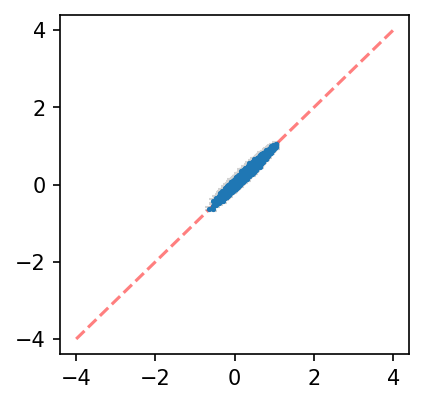

In [80]:
fig, ax = plt.subplots(figsize=(3, 3), dpi=150)
ax.errorbar(
    x=df_plot.GV,
    y=df_plot.PRS_MEAN,
    yerr=(
        df_plot.PRS_MEAN - df_plot.PRS_LOWER,
        df_plot.PRS_UPPER - df_plot.PRS_MEAN,
    ),
    ecolor="lightgray",
    fmt=".",
    markersize=3,
    elinewidth=1.0,
    capsize=2,
)
plt.plot([-4, 4], [-4, 4], color="red", ls="--", alpha=0.5)

In [2]:
df_info = pd.read_csv(join(data_dir, "chr22_h2_0.5_cau_0.1.sim_0.csv.gz"), index_col=0)
intercept = df_info.GV.mean() - df_info["PRS_MEAN"].mean()
for col in ["PRS_MEAN", "PRS_LOWER", "PRS_UPPER"]:
    df_info[col] += intercept

NameError: name 'data_dir' is not defined

In [ ]:
for pop in ["EUR", "ADMIX"]:
    df_subset = df_info[df_info.POP == pop]
    coverage = np.mean(
        (df_subset.PRS_LOWER <= df_subset.GV) & (df_subset.GV < df_subset.PRS_UPPER)
    )
    print(pop, coverage)